<a href="https://colab.research.google.com/github/mixidota2/kaggle-indoor/blob/main/notebook/Indoor_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
- 基本はBaselineのLSTM
- ネットワークはそのままで、いろいろ効きそうな処理を追加する


In [1]:
!nvidia-smi

Thu Apr 22 08:49:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
os.chmod(filename, 600)

In [3]:
!kaggle datasets download -d kokitanisaka/indoorunifiedwifids
!unzip indoorunifiedwifids.zip > /dev/null

 98% 453M/463M [00:05<00:00, 79.7MB/s]
100% 463M/463M [00:05<00:00, 89.4MB/s]


In [4]:
import os
import gc
import glob 
import copy
import pickle
import random

import pandas as pd
import numpy as np

import yaml
from tqdm import tqdm
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt

import cv2

import scipy.stats as stats

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

tqdm.pandas(position=0, leave=True)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
# consts
N_SPLITS = 5

SEED = 42

NUM_FEATS = 20

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
def get_timestamp():
    import time
    timestamp = ''
    for i, d in enumerate(time.localtime()):
        if i == 3:
            d += 8
        timestamp += str(d) + '-'
        if i == 4:
            break
    return timestamp[:-1]
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt((xhat-x)**2 + (yhat-y)**2) + 15 * np.abs(fhat-f)
#     intermediate = np.sqrt((xhat-x)**2 + (yhat-y)**2)
    return intermediate.sum()/xhat.shape[0]

## Preprocess

In [7]:
with open(f'train_all.pkl', 'rb') as f:
  data = pickle.load( f)
with open(f'test_all.pkl', 'rb') as f:
  test_data = pickle.load(f)

In [8]:
# count n features
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

In [9]:
# get unique wifi bssids
wifi_bssids = []
for i in range(100):
    wifi_bssids.extend(data.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES: {wifi_bssids_size}')

wifi_bssids_test = []
for i in range(100):
    wifi_bssids_test.extend(test_data.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES: {wifi_bssids_size}')

wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)

BSSID TYPES: 61206
BSSID TYPES: 33042


In [10]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(data['site_id'])

ss = StandardScaler()
ss.fit(data.loc[:,RSSI_FEATS])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
# apply transforms

data.loc[:,RSSI_FEATS] = ss.transform(data.loc[:,RSSI_FEATS])
for i in BSSID_FEATS:
    data.loc[:,i] = le.transform(data.loc[:,i])
    data.loc[:,i] = data.loc[:,i] + 1
    
data.loc[:, 'site_id'] = le_site.transform(data.loc[:, 'site_id'])

data.loc[:,RSSI_FEATS] = ss.transform(data.loc[:,RSSI_FEATS])

In [12]:
test_data.loc[:,RSSI_FEATS] = ss.transform(test_data.loc[:,RSSI_FEATS])
for i in BSSID_FEATS:
    test_data.loc[:,i] = le.transform(test_data.loc[:,i])
    test_data.loc[:,i] = test_data.loc[:,i] + 1
    
test_data.loc[:, 'site_id'] = le_site.transform(test_data.loc[:, 'site_id'])

test_data.loc[:,RSSI_FEATS] = ss.transform(test_data.loc[:,RSSI_FEATS])

In [13]:
site_count = len(data['site_id'].unique())
data.reset_index(drop=True, inplace=True)

In [14]:
seed_everything(SEED)

## Some EDA

In [15]:
#plt.figure(figsize=(10,3))
#max_iter = 10
#for i, (name, group) in enumerate(data.groupby("path")):
#    sns.lineplot(data=group, y=RSSI_FEATS[0], x=range(group.shape[0]))
#    if i > max_iter:
#        break
#plt.figure(figsize=(10,3))
#for i, (name, group) in enumerate(data.groupby("path")):
#    sns.lineplot(data=group, y="x", x=range(group.shape[0]))
#    if i > max_iter:
#        break
#plt.figure(figsize=(10,3))
#for i, (name, group) in enumerate(data.groupby("path")):
#    sns.lineplot(data=group, y="y", x=range(group.shape[0]))
#    if i > max_iter:
#        break

In [16]:
data.columns

Index(['bssid_0', 'bssid_1', 'bssid_2', 'bssid_3', 'bssid_4', 'bssid_5',
       'bssid_6', 'bssid_7', 'bssid_8', 'bssid_9',
       ...
       'rssi_95', 'rssi_96', 'rssi_97', 'rssi_98', 'rssi_99', 'x', 'y',
       'floor', 'path', 'site_id'],
      dtype='object', length=205)

In [17]:
tmp = data[['x','path']].iloc[0:1000]
tmp.head(10)

,x,path
0,107.85044,5e1580adf4c3420006d520d4
1,107.85044,5e1580adf4c3420006d520d4
2,98.33065,5e1580adf4c3420006d520d4
3,98.33065,5e1580adf4c3420006d520d4
4,98.33065,5e1580adf4c3420006d520d4
5,156.77786,5e1581c71506f2000638fc78
6,156.77786,5e1581c71506f2000638fc78
7,156.77786,5e1581c71506f2000638fc78
8,154.99240,5e1581c71506f2000638fc78
9,154.99240,5e1581c71506f2000638fc78


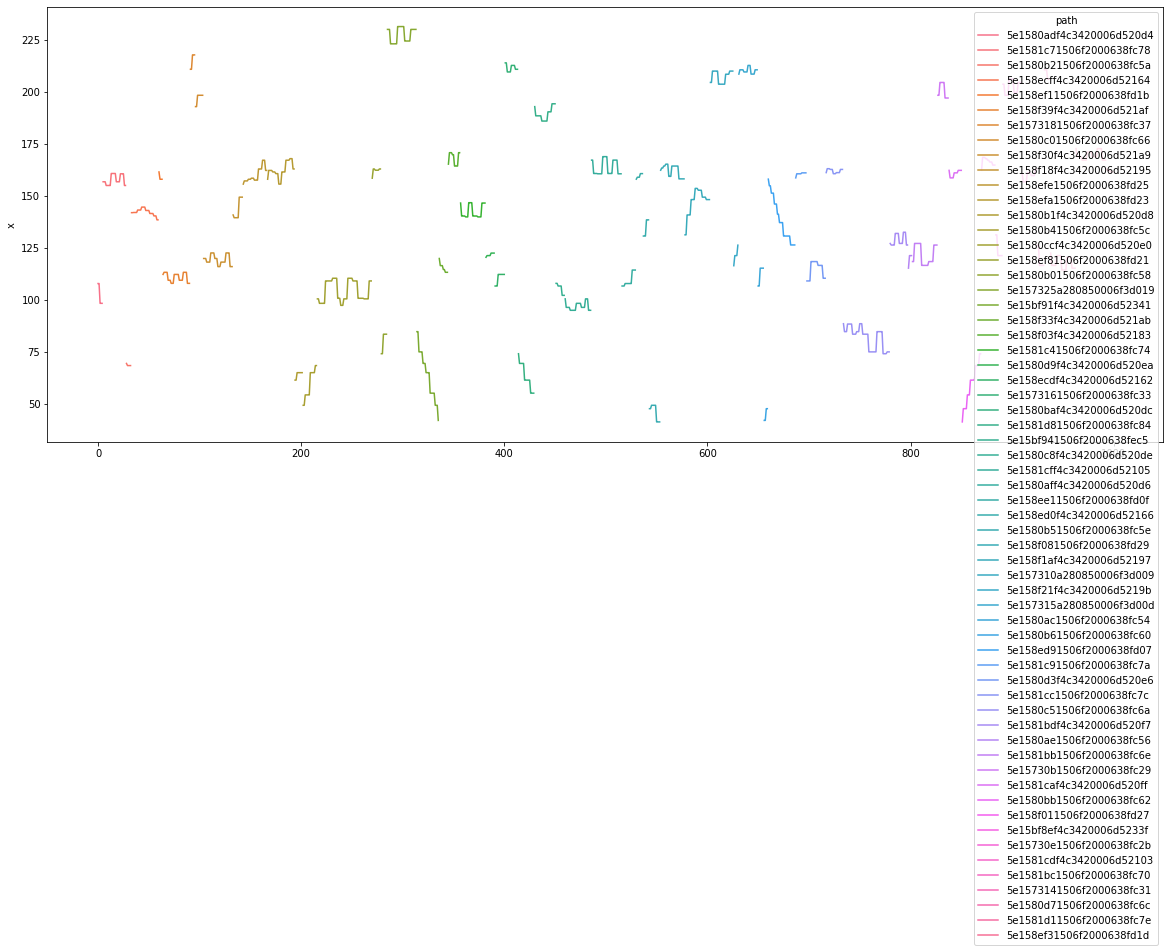

In [18]:
plt.figure(figsize=(20,8))
sns.lineplot(data=tmp, x=tmp.index, y='x', hue='path')

## Modeling

In [19]:
class IndoorDataset(Dataset):
    def __init__(self, data, flag='TRAIN', seq_len=5):
        self.data = data
        self.flag = flag
        self.seq_len = seq_len
    def __len__(self):
        #return self.data.shape[0] - self.seq_len - 1
        return self.data.shape[0]
    def __getitem__(self, index):
        #tmp_data = self.data.iloc[index * self.seq_len:(index + 1) * self.seq_len]
        tmp_data = self.data.iloc[index:index + self.seq_len]
        if tmp_data.shape[0] != self.seq_len:
            temp_len = tmp_data.shape[0]
            diff = self.seq_len - temp_len
            #print("temp_len: ",temp_len)
            #print("diff: ",diff)
            #print("tmp_data shape", tmp_data.shape)
            for i in range(diff):
                _temp = tmp_data.iloc[-1,:]
                tmp_data = tmp_data.append(_temp)
                #print("tmp_data shape", tmp_data.shape)
            
        if self.flag == 'TRAIN':
            return {
                'BSSID_FEATS':tmp_data[BSSID_FEATS].values.astype(float),
                'RSSI_FEATS':tmp_data[RSSI_FEATS].values.astype(float),
                'site_id':tmp_data['site_id'].values.astype(int),
                'x':tmp_data['x'].values,
                'y':tmp_data['y'].values,
                'floor':tmp_data['floor'].values,
            }
        else:
            return {
                'BSSID_FEATS':tmp_data[BSSID_FEATS].values.astype(float),
                'RSSI_FEATS':tmp_data[RSSI_FEATS].values.astype(float),
                'site_id':tmp_data['site_id'].values.astype(int)
            }

In [20]:
#train_dataset = IndoorDataset(data.iloc[:1000,:])
#data.shape, len(train_dataset)
#device = 'cuda'
#pbar = tqdm(DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1, pin_memory=True), position=0)
#for temp in pbar:
#    pass
    #print(temp['BSSID_FEATS'].to(device).long())
    #break
#temp['BSSID_FEATS'].to(device).long().size()
#_temp = data.copy()
#temp = data.iloc[-1,:]
#temp = pd.concat([_temp,temp])
#temp.shape

In [21]:
class SimpleLSTM(nn.Module):
    def __init__(self, embedding_dim = 64, seq_len=20, site_dim=2):
        super(SimpleLSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.seq_len = seq_len
        self.site_dim = site_dim
        self.emb_BSSID_FEATS = nn.Embedding(wifi_bssids_size, embedding_dim)
        self.emb_site_id = nn.Embedding(site_count, site_dim)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128, dropout=0.3, bidirectional=False, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16, dropout=0.1, bidirectional=False, batch_first=True)
        self.lr = nn.Linear(NUM_FEATS, NUM_FEATS * embedding_dim)
        self.lr1 = nn.Linear(NUM_FEATS * embedding_dim + NUM_FEATS * embedding_dim + site_dim, 256)
        self.lr_xy = nn.Linear(16, 2)
        self.lr_floor = nn.Linear(16, 1)
        #self.batch_norm1 = nn.BatchNorm1d(NUM_FEATS)
        #self.batch_norm1 = nn.LayerNorm(NUM_FEATS)
        self.batch_norm1 = nn.LayerNorm(NUM_FEATS * embedding_dim)
        #self.batch_norm2 = nn.BatchNorm1d(NUM_FEATS * embedding_dim + NUM_FEATS * embedding_dim + site_dim)
        #self.batch_norm2 = nn.LayerNorm(NUM_FEATS * embedding_dim + NUM_FEATS * embedding_dim + site_dim)
        self.batch_norm2 = nn.LayerNorm(256)
        #self.batch_norm3 = nn.BatchNorm1d(1)
        #self.batch_norm3 = nn.LayerNorm(256)
        self.batch_norm3 = nn.LayerNorm(2)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        
        x_bssid = self.emb_BSSID_FEATS(x['BSSID_FEATS'])
        x_bssid = torch.flatten(x_bssid, start_dim=-2)
        
        x_site_id = self.emb_site_id(x['site_id'])
        x_site_id = torch.flatten(x_site_id, start_dim=-1)

        #x_rssi = self.batch_norm1(x['RSSI_FEATS'])
        x_rssi = self.lr(x['RSSI_FEATS'])
        x_rssi = self.batch_norm1(x_rssi)
        x_rssi = torch.relu(x_rssi)
        #x_rssi = self.dropout(x_rssi)
        
        x = torch.cat([x_bssid, x_site_id, x_rssi], dim=-1)
        x = self.lr1(x)
        x = self.batch_norm2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        #x = x.unsqueeze(-2)
        #x = self.batch_norm3(x)
        
        #x = x.reshape(self.seq_len, -1, 256) # (all_seq, 1, feat) -> (seq_len, batch, feat)
        #x = x.transpose(0, 1)
        x, _ = self.lstm1(x)
        #x = x.transpose(0, 1)
        x = torch.relu(x)
        #x = x.transpose(0, 1)
        x, _ = self.lstm2(x)
        #x = x.transpose(0, 1)
        x = torch.relu(x)
        #x = x.reshape(-1, 16)
        xy = self.lr_xy(x)
        #xy = self.batch_norm3(xy)
        floor = self.lr_floor(x)
        floor = torch.relu(floor)
        return xy.squeeze(-2), floor.squeeze(-2)

In [22]:
def evaluate(net, data_loader,  device='cuda'):
    net.to(device)
    net.eval()
    x_list = []
    y_list = []
    floor_list = []
    prexs_list = []
    preys_list = []
    prefloors_list = []
    for d in tqdm(data_loader, position=0):
        data_dict = {}
        data_dict['BSSID_FEATS'] = d['BSSID_FEATS'].to(device).long()
        data_dict['RSSI_FEATS'] = d['RSSI_FEATS'].to(device).float()
        data_dict['site_id'] = d['site_id'].to(device).long()
        x = d['x'].to(device).float()
        y = d['y'].to(device).float()
        floor = d['floor'].to(device).long()
        x_list.append(x.cpu().detach().numpy())
        y_list.append(y.cpu().detach().numpy())
        floor_list.append(floor.cpu().detach().numpy())
        xy, floor = net(data_dict)
        prexs_list.append(xy[:, :, 0].cpu().detach().numpy())
        preys_list.append(xy[:, :, 1].cpu().detach().numpy())
        prefloors_list.append(floor.squeeze().cpu().detach().numpy())
    x = np.concatenate(x_list)
    y = np.concatenate(y_list)
    floor = np.concatenate(floor_list)
    prexs = np.concatenate(prexs_list)
    preys =np.concatenate(preys_list)
    prefloors = np.concatenate(prefloors_list)
    eval_score = comp_metric(x, y, floor, prexs, preys, prefloors)
    return eval_score
def get_result(net, data_loader, device='cuda'):
    net.eval()
    net.to(device)
    prexs_list = []
    preys_list = []
    prefloors_list = []
    data_dict = {}
    for d in tqdm(data_loader, position=0):
        data_dict['BSSID_FEATS'] = d['BSSID_FEATS'].to(device).long()
        data_dict['RSSI_FEATS'] = d['RSSI_FEATS'].to(device).float()
        data_dict['site_id'] = d['site_id'].to(device).long()
        xy, floor = net(data_dict)
        prexs_list.append(xy[:, 0, 0].cpu().detach().numpy().reshape(-1,1).squeeze())
        preys_list.append(xy[:, 0, 1].cpu().detach().numpy().reshape(-1,1).squeeze())
        prefloors_list.append(floor[:,0].squeeze(-1).cpu().detach().numpy().reshape(-1,1).squeeze())
    prexs = np.concatenate(prexs_list)
    preys =np.concatenate(preys_list)
    prefloors = np.concatenate(prefloors_list)
    #prefloors = np.argmax(prefloors,axis=1)
    return prexs, preys, prefloors

In [23]:
#score = evaluate(net, valid_dataloader, device)
#test_x, test_y, test_floor = get_result(best_model, test_dataloader, device)

## Training

In [24]:
SEQ_LEN = 5
BATCH_SIZE = 128
EMB_DIM = 64
SITE_DIM = 2
NUM_EPOCHS = 15
DEBUG = False
if DEBUG:
    inputs_data = data.iloc[:1000]
    NUM_EPOCHS = 5
else:
    inputs_data = data

score_df = pd.DataFrame()
oof = list()
predictions = list()

oof_x, oof_y, oof_f = np.zeros(inputs_data.shape[0]), np.zeros(inputs_data.shape[0]), np.zeros(inputs_data.shape[0])
preds_x, preds_y = 0, 0
preds_f_arr = np.zeros((test_data.shape[0], N_SPLITS))


for fold, (trn_idx, val_idx) in enumerate(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED).split(inputs_data.loc[:, 'path'], inputs_data.loc[:, 'path'])):

    train_data = inputs_data.loc[trn_idx]
    valid_data = inputs_data.loc[val_idx]
    train_dataset = IndoorDataset(train_data, seq_len=SEQ_LEN)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    valid_dataset = IndoorDataset(valid_data, seq_len=SEQ_LEN)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_dataset = IndoorDataset(test_data, 'TEST', seq_len=SEQ_LEN)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = SimpleLSTM(embedding_dim=EMB_DIM, site_dim=SITE_DIM)
    net = net.to(device)

    mse = nn.MSELoss()
    mse = mse.to(device)
    optim = torch.optim.Adam(net.parameters(), lr=5e-3)

    best_loss = 10000000000
    best_epoch = 0
    for epoch in range(NUM_EPOCHS):
        net.train()
        losses = []
        pbar = tqdm(train_dataloader, position=0)
        for d in pbar:
            data_dict = {}
            data_dict['BSSID_FEATS'] = d['BSSID_FEATS'].to(device).long()
            data_dict['RSSI_FEATS'] = d['RSSI_FEATS'].to(device).float()
            data_dict['site_id'] = d['site_id'].to(device).long()
            x = d['x'].to(device).float().unsqueeze(-1)
            y = d['y'].to(device).float().unsqueeze(-1)
            floor = d['floor'].to(device).long()
            xy, floor = net(data_dict)
            label = torch.cat([x, y], dim=-1)
            loss = mse(xy, label)
            loss.backward()
            optim.step()
            optim.zero_grad()
            losses.append(loss.cpu().detach().numpy())
            pbar.set_description(f'loss:{np.mean(losses)}')
            data_dict['BSSID_FEATS'] = data_dict['BSSID_FEATS'].detach()
            data_dict['RSSI_FEATS'] = data_dict['RSSI_FEATS'].detach()
            data_dict['site_id'] = data_dict['site_id'].detach()
            #del x, y, xy, floor, label, data_dict, loss, d
            gc.collect()
            torch.cuda.empty_cache()
        score = evaluate(net, valid_dataloader, device)
        if score < best_loss:
            best_loss = score
            best_epoch = epoch
            best_model = copy.deepcopy(net)
        if best_epoch + 2 < epoch:
            break
        print("*="*50)
        print(f"fold {fold} EPOCH {epoch}: mean position error {score}")
        print("*="*50)
    test_x, test_y, test_floor = get_result(best_model, test_dataloader, device)
    preds_f_arr[:,fold] = test_floor
    preds_x += test_x
    preds_y += test_y

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 0: mean position error 613.3680478141567
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 1: mean position error 530.15114120892
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 2: mean position error 529.5968717966256
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 3: mean position error 529.9717037634485
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 4: mean position error 531.1637528698084
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 5: mean position error 368.9116773709715
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 6: mean position error 356.34775954093794
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 7: mean position error 224.55827021853608
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 8: mean position error 189.0211394034479
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 9: mean position error 175.2159388157154
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 10: mean position error 169.23464379327544
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 11: mean position error 164.90668226962612
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 12: mean position error 163.28116283065535
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 13: mean position error 161.72190043470545
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/80 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 14: mean position error 160.7244916355668
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 0: mean position error 642.491143978508
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 1: mean position error 541.013456511778
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 2: mean position error 535.166266273241
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 3: mean position error 536.3475615695429
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 4: mean position error 536.2440405773441
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 5: mean position error 373.2922930371977
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 6: mean position error 232.08688538956565
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 7: mean position error 190.9501506326937
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 8: mean position error 176.77016883015727
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 9: mean position error 169.34726740270762
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 10: mean position error 165.90427185387412
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 11: mean position error 163.64728949200725
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 12: mean position error 162.40930071654367
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 13: mean position error 161.08893466351094
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/80 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 14: mean position error 160.26539268036393
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 0: mean position error 642.5554545674053
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 1: mean position error 539.9498724827588
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 2: mean position error 533.807357685313
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 3: mean position error 534.9056038325238
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 4: mean position error 534.8898511394347
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 5: mean position error 378.14902647781395
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 6: mean position error 246.6853316032509
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 7: mean position error 195.5943850843372
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 8: mean position error 178.35878675973913
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 9: mean position error 171.35925248408859
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 10: mean position error 166.93305092474301
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 11: mean position error 164.59113701367184
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 12: mean position error 163.1701150965335
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 13: mean position error 161.85076883947153
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/80 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 14: mean position error 161.14242362352746
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 0: mean position error 620.1399772874607
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 1: mean position error 536.0636384996996
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 2: mean position error 535.4524444848873
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 3: mean position error 536.0801783609691
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 4: mean position error 535.9093009032222
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 5: mean position error 331.35623861397215
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 6: mean position error 238.32537987757306
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 7: mean position error 199.5981591415276
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 8: mean position error 181.76795055289867
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 9: mean position error 172.8738975300903
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 10: mean position error 168.3454684571315
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 11: mean position error 165.81802478105544
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 12: mean position error 163.84779679256067
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 13: mean position error 162.25498848166546
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/80 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 14: mean position error 161.15278198746293
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 0: mean position error 588.545134438099
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 1: mean position error 522.5719294043627
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 2: mean position error 524.1882635823363
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 3: mean position error 524.354273660553
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 4: mean position error 455.4812924661994
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 5: mean position error 372.19122379648053
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 6: mean position error 252.60334680486895
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 7: mean position error 199.8329522829958
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 8: mean position error 178.3423995217635
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 9: mean position error 170.32084032728605
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 10: mean position error 165.95693073408907
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 11: mean position error 165.16066519561346
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 12: mean position error 162.22061895299365
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/1614 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 13: mean position error 162.18082768180628
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/80 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 14: mean position error 160.73773676780394
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


100%|██████████| 80/80 [00:07<00:00, 10.64it/s]


In [42]:
test_floor.shape, test_x.shape, test_data.shape, xy.shape
#preds_f_arr.shape

((50665,), (20266,), (10133, 202), torch.Size([32, 5, 2]))

In [1]:
preds_x

NameError: ignored

In [25]:
subm = pd.read_csv('sample_submission.csv', index_col=0)

test_x = preds_x / (fold + 1) 
test_y = preds_y /(fold + 1)
print("*+"*40)
# as it breaks in the middle of cross-validation, the score is not accurate at all.
score = comp_metric(oof_x, oof_y, oof_f, data.iloc[:, -5].to_numpy(), data.iloc[:, -4].to_numpy(), data.iloc[:, -3].to_numpy())
oof.append(score)
print(f"mean position error {score}")
print("*+"*40)
preds_f_mode = stats.mode(preds_f_arr, axis=1)
preds_f = preds_f_mode[0].astype(int).reshape(-1)
test_preds = pd.DataFrame(np.stack((preds_f, test_x, test_y))).T
test_preds.columns = subm.columns
test_preds.index = test_data["site_path_timestamp"]
test_preds["floor"] = test_preds["floor"].astype(int)
predictions.append(test_preds)

*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+
mean position error 192.2107121781046
*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+


In [26]:
all_preds = pd.concat(predictions)
all_preds = all_preds.reindex(subm.index)

In [27]:
simple_accurate_99 = pd.read_csv('submission_99.csv')
all_preds['floor'] = simple_accurate_99['floor'].values

In [28]:
all_preds.to_csv('submission.csv')

## Post Processing

In [29]:
!git clone --depth 1 https://github.com/location-competition/indoor-location-competition-20 indoor_location_competition_20 > /dev/null
!rm -rf indoor_location_competition_20/data > /dev/null

Cloning into 'indoor_location_competition_20'...
remote: Enumerating objects: 1169, done.
remote: Counting objects: 100% (1169/1169), done.
remote: Compressing objects: 100% (1131/1131), done.
remote: Total 1169 (delta 38), reused 1167 (delta 38), pack-reused 0
Receiving objects: 100% (1169/1169), 411.37 MiB | 21.26 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Checking out files: 100% (1145/1145), done.


In [30]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.12
!mkdir indoor_dataset
!kaggle competitions download -c indoor-location-navigation -p indoor_dataset 
!unzip -o -d indoor_dataset indoor_dataset/indoor-location-navigation.zip `zipinfo -1 indoor_dataset/indoor-location-navigation.zip | grep 'test'`

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.5MB 7.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 4.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=bd46d150775fa32f29c17172faf1d384e4dadb603dc7bad8c33dc1692f5503bb
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
100% 12.7G/12.7G [02:36<00:00, 72.8MB/s]
100% 12.7G/12.7G [02:36<00:00, 87.2MB/s]
y
yes
Yes


In [31]:
!unzip indoor_dataset/indoor-location-navigation.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: train/5da1382d4db8ce0c98bbe92e/F1/5da7e38aaec4b20006154bf3.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F1/5da7e38baec4b20006154bf5.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F1/5da7e38c476f600006adcdef.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F1/5da7e38caec4b20006154bf7.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F1/5da7e38daec4b20006154bf9.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F1/5da7e38daec4b20006154bfb.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F1/5da7e38e476f600006adcdf1.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F1/5da7e391aec4b20006154bfd.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F2/5da42e501261860006629deb.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F2/5da42e6093f1580006d7d0f0.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F2/5da42e911261860006629dee.txt  
  inflating: train/5da1382d4db8ce0c98bbe92e/F2/5da42e951261860006629df0.txt  
  inflating: train/5da1382d4db8c

In [32]:
import multiprocessing
import numpy as np
import pandas as pd
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [33]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{INPUT_PATH}/test/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [34]:
INPUT_PATH = './indoor_dataset'

sub = pd.read_csv('submission.csv')
tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub = pd.concat(dfs).sort_values('site_path_timestamp')
sub.to_csv('submission_002.csv', index=False)

626it [04:54,  2.13it/s]


## Check Tensor Shapes

In [ ]:
#tmp = data.loc[:9,BSSID_FEATS]
tmp = temp['BSSID_FEATS'].long()
#tmp_ids = []
#for i in range(20):
#    tmp_ids.extend(tmp.iloc[:,i].values.tolist())
#tmp_ids = len(list(set(tmp_ids)))
_emb = nn.Embedding(wifi_bssids_size, 64)
#_res = _emb(torch.tensor(tmp.values.astype(float)).long())
_res = _emb(tmp)
_res = torch.flatten(_res, start_dim=-2)
#torch.tensor(tmp.values).size()

#tmp2 = data.loc[:9,RSSI_FEATS]
tmp2 = temp['RSSI_FEATS']
#tmp2_ids = []
#for i in range(20):
#    tmp2_ids.extend(tmp2.iloc[:,i].values.tolist())
#tmp2_ids = len(list(set(tmp2_ids)))
lr = nn.Linear(20, 1280)
_res2 = lr(tmp2.float())

#tmp3 = data.loc[:9,"site_id"]
tmp3 = temp['site_id']
_emb2 = nn.Embedding(site_count, 2)
_res3 = _emb2(tmp3.long())
_res3 = torch.flatten(_res3, start_dim=-1)

In [ ]:
_res.size(), _res2.size(), _res3.size()

In [ ]:
_all = torch.cat([_res, _res2, _res3], dim=-1)
_all = nn.Linear(2562, 256)(_all)

In [ ]:
_all.size()

In [ ]:
#_un = _all.unsqueeze(-2)
_un = _all.clone()
_un.size()

In [ ]:
#_tr = _un.transpose(0, 1)
#_tr = _tr.transpose(0, 1)
_tr = _un.clone()
_tr.size()

In [ ]:
_lstm1 = nn.LSTM(input_size=256,hidden_size=128, dropout=0.3, bidirectional=False, batch_first=True)
_ls1, _ = _lstm1(_tr)
_ls1.size()

In [ ]:
#_xy = _ls1.transpose(0, 1)
#_xy = _ls1.reshape(-1,128)
_xy = _ls1.clone()
_xy = nn.Linear(128,2)(_xy)
_xy.size()

In [ ]:
_xy.squeeze(-2).size()

In [ ]:
_tr.flatten().size()

In [ ]:
x = temp['x'].float().unsqueeze(-1)
y = temp['y'].float().unsqueeze(-1)
floor = temp['floor'].long()
#xy, floor = net(data_dict)
label = torch.cat([x, y], dim=-1)
#loss = mse(xy, label)
floor.size()

# Some EDA

In [ ]:
from pathlib import Path
base_path = Path('./')
train_path = base_path / 'train'
trains = list(train_path.glob('**/*.txt'))
temp = read_data_file(trains[0])

In [ ]:
temp.acce.shape, temp.acce_uncali.shape, temp.wifi.shape, temp.waypoint.shape, temp.ahrs.shape, temp.gyro.shape, temp.ibeacon.shape, temp.magn.shape

In [ ]:
temp.acce